# Performance improvements with MOCs

This notebook assesses the latest performance improvements implemented on LSDB for crossmatching/joining catalogs with different HiPSCat structures. To crossmatch two catalogs we need to find the partitions of both catalogs that overlap with the desired region in the sky. If one of the catalogs is densely populated in the region, i.e. it has pixels of very high order, while the second one is sparse, i.e. it has pixels of very small order, performance issues arise, because we will need to load into memory data that of the less densely populated catalog that is irrelevant to our crossmatch.

Remember that partitions are files on disk, therefore, the larger number of files we need to read the more computationally expensive the task of crossmatching is. Our goal is to load only the data that we need according to the catalogs' multi-order coverage maps. They are essentially histograms based on the HEALPix partitioning that keep track of the number of catalog points in the sky.

In [1]:
import lsdb
from lsdb.dask.merge_catalog_functions import align_catalogs, align_trees

In [2]:
from dask.distributed import Client
client = Client(n_workers=4, threads_per_worker=1, memory_limit="12Gb", dashboard_address=':38766')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38766/status,
Dashboard: http://127.0.0.1:38766/status,Workers: 4
Total threads: 4,Total memory: 44.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38351,Workers: 4
Dashboard: http://127.0.0.1:38766/status,Total threads: 4
Started: Just now,Total memory: 44.70 GiB
Comm: tcp://127.0.0.1:43529,Total threads: 1
Dashboard: http://127.0.0.1:42910/status,Memory: 11.18 GiB
Nanny: tcp://127.0.0.1:36671,


In [3]:
gaia = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/gaia_dr3/gaia")

Let's prove that there are no longer bottlenecks on this type of workflows. First, we will import MagE, a catalog of approximately 131 objects scattered across the southern sky. The pixels generated in the importing stage are all large, at order 0. 

In [4]:
from astropy.table import Table
mage_df = Table.read("mage_bonaca_rcat_V0.05.fits", format="fits").to_pandas()
print(f"Num of objects: {len(mage_df)}")

Num of objects: 131


The `from_dataframe` interface should be simple and (as much as possible) partition-agnostic to the users. They should not need to specify a `lowest_order` to ensure the operations with denser catalogs (or vice-versa) are performed efficiently.

In [5]:
mage = lsdb.from_dataframe(
    mage_df,
    catalog_name="MagE",
    catalog_type="object",
    ra_column="GAIAEDR3_RA",
    dec_column="GAIAEDR3_DEC",
    # lowest_order=7,
    # highest_order=10,
    # threshold=100
)
mage

,name,date,specfile,mage_ra,mage_dec,mage_target,mage_decker,mage_binning,mage_mjd,mage_airmass,mage_exptime,tdb_source_id,tdb_ra,tdb_dec,tdb_selection,H3_ID,PS_ID,TMASS_ID,WISE_ID,UNWISE_ID,GAIAEDR3_ID,GAIADR1_ID,TILE_ID,RA,DEC,RA_S,DEC_S,L,B,EBV,BHB,MGIANT,RAND,GUIDE,XFIT_RANK,PS_G,PS_R,PS_I,PS_Z,PS_Y,SDSS_U,SDSS_G,SDSS_R,SDSS_I,SDSS_Z,TMASS_J,TMASS_H,TMASS_K,WISE_W1,WISE_W2,UNWISE_W1,UNWISE_W2,GAIAEDR3_G,GAIAEDR3_BP,GAIAEDR3_RP,PS_G_ERR,PS_R_ERR,PS_I_ERR,PS_Z_ERR,PS_Y_ERR,SDSS_U_ERR,SDSS_G_ERR,SDSS_R_ERR,SDSS_I_ERR,SDSS_Z_ERR,TMASS_J_ERR,TMASS_H_ERR,TMASS_K_ERR,WISE_W1_ERR,WISE_W2_ERR,UNWISE_W1_ERR,UNWISE_W2_ERR,GAIAEDR3_G_ERR,GAIAEDR3_BP_ERR,GAIAEDR3_RP_ERR,GAIAEDR3_RA,GAIAEDR3_DEC,GAIAEDR3_RA_ERROR,GAIAEDR3_DEC_ERROR,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PARALLAX_OVER_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMDEC,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PSEUDOCOLOUR,GAIAEDR3_PSEUDOCOLOUR_ERROR,GAIAEDR3_NU_EFF_USED_IN_ASTROMETRY,GAIAEDR3_ASTROMETRIC_PARAMS_SOLVED,GAIAEDR3_PHOT_BP_RP_EXCESS_FACTOR,GAIAEDR3_VISIBILITY_PERIODS_USED,GAIAEDR3_RUWE,GAIAEDR3_IPD_GOF_HARMONIC_AMPLITUDE,GAIAEDR3_G_CORRECTED,GAIAEDR3_PARALLAX_CORRECTED,GAIAEDR3_PHOT_BP_RP_EXCESS_FACTOR_CORRECTED,GAIAEDR3_PARALLAX_PMRA_CORR,GAIAEDR3_PARALLAX_PMDEC_CORR,GAIAEDR3_PMRA_PMDEC_CORR,GAIAEDR3_RA_DEC_CORR,GAIAEDR3_RA_PARALLAX_CORR,GAIAEDR3_RA_PMRA_CORR,GAIAEDR3_RA_PMDEC_CORR,GAIAEDR3_DEC_PARALLAX_CORR,GAIAEDR3_DEC_PMRA_CORR,GAIAEDR3_DEC_PMDEC_CORR,WISE_CC_FLAGS,WISE_EXT_FLAG,ACAT_ID,EEP,EEP_lerr,EEP_uerr,EEP_err,init_FeH,init_FeH_lerr,init_FeH_uerr,init_FeH_err,init_aFe,init_aFe_lerr,init_aFe_uerr,init_aFe_err,init_Mass,init_Mass_lerr,init_Mass_uerr,init_Mass_err,pc_0,pc_0_lerr,pc_0_uerr,pc_0_err,pc_1,pc_1_lerr,pc_1_uerr,pc_1_err,pc_2,pc_2_lerr,pc_2_uerr,pc_2_err,pc_3,pc_3_lerr,pc_3_uerr,pc_3_err,Inst_R,Inst_R_lerr,Inst_R_uerr,Inst_R_err,Teff,Teff_lerr,Teff_uerr,Teff_err,logg,logg_lerr,logg_uerr,logg_err,logR,logR_lerr,logR_uerr,logR_err,FeH,FeH_lerr,FeH_uerr,FeH_err,aFe,aFe_lerr,aFe_uerr,aFe_err,Vrad,Vrad_lerr,Vrad_uerr,Vrad_err,Vrot,Vrot_lerr,Vrot_uerr,Vrot_err,Dist,Dist_lerr,Dist_uerr,Dist_err,Av,Av_lerr,Av_uerr,Av_err,logAge,logAge_lerr,logAge_uerr,logAge_err,Mass,Mass_lerr,Mass_uerr,Mass_err,logL,logL_lerr,logL_uerr,logL_err,Para,Para_lerr,Para_uerr,Para_err,Age,Age_lerr,Age_uerr,Age_err,lnZ,lnL,lnP,chisq_spec,nspecpix,chisq_phot,nbands,spec_snr,R_gal,R_gal_err,X_gal,X_gal_err,Y_gal,Y_gal_err,Z_gal,Z_gal_err,Vx_gal,Vx_gal_err,Vy_gal,Vy_gal_err,Vz_gal,Vz_gal_err,Vr_gal,Vr_gal_err,Vphi_gal,Vphi_gal_err,Vtheta_gal,Vtheta_gal_err,V_tan,V_tan_err,V_gsr,V_gsr_err,Lx,Lx_err,Ly,Ly_err,Lz,Lz_err,Ltot,Ltot_err,E_kin_pot1,E_kin_pot1_err,E_pot_pot1,E_pot_pot1_err,E_tot_pot1,E_tot_pot1_err,circLz_pot1,circLz_pot1_err,circLtot_pot1,circLtot_pot1_err,FLAG,dup,Sgr_l,Sgr_b,Sgr_FLAG,Norder,Dir,Npix
npartitions=8,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4611686018427387904,binary[pyarrow],binary[pyarrow],binary[pyarrow],double[pyarrow],double[pyarrow],binary[pyarrow],binary[pyarrow],binary[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],binary[pyarrow],int32[pyarrow],int32[pyarrow],binary[pyarrow],binary[pyarrow],binary[pyarrow],int64[pyarrow],int32[pyarrow],null[pyarrow],double[pyarrow],double[pyarrow],null[pyarrow],null[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],int16[pyarrow],double[pyarrow],int16[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow]

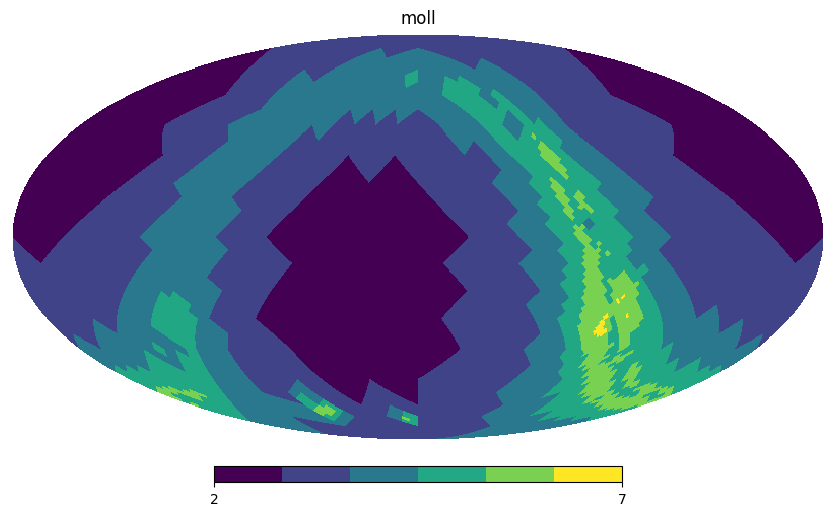

In [6]:
gaia.plot_pixels()

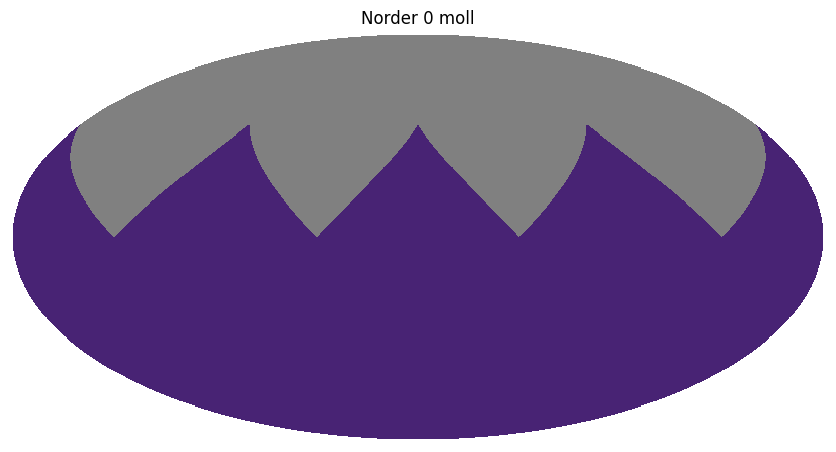

In [7]:
mage.plot_pixels()

We now generate a MOC (by default at order 10) when we create the catalog. It allows us to filter out the partitions of the denser catalog we won't need to load because the first covers a lot more area that we don't need. 

The partitions at order 0 of the MagE catalog will be matched to partitions in Gaia that range from order 2 to 7. These big pixels at order 0 previously required all small pixels of Gaia in that region to be loaded (even though the region we want to crossmatch with in MagE is mostly empty!).

In [8]:
mage.hc_structure.moc is not None

True

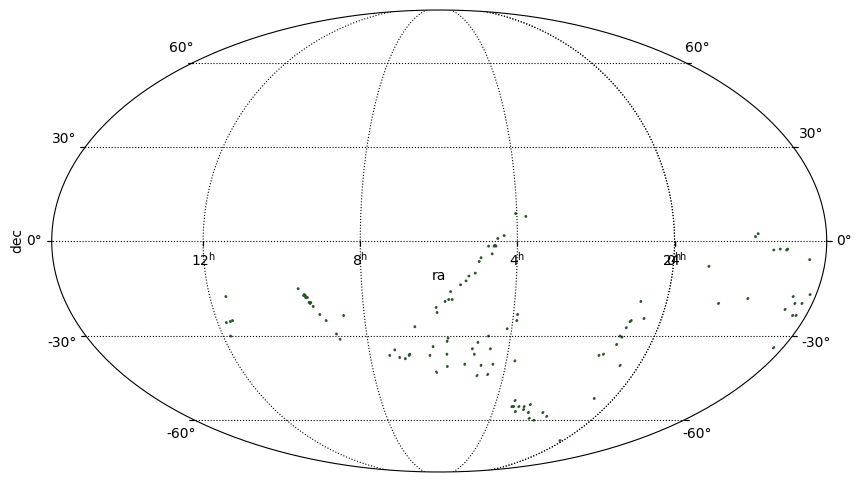

In [9]:
from matplotlib import pyplot as plt
from mocpy import WCS
from astropy import units as u
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle

fig = plt.figure(111, figsize=(10, 6))

with WCS(
    fig,
    fov=160 * u.deg,
    center=SkyCoord(90, 0, unit="deg", frame="icrs"),
    coordsys="icrs",
    rotation=Angle(0, u.degree),
    projection="MOLL",
) as wcs:
    ax = fig.add_subplot(1, 1, 1, projection=wcs, frame_class=EllipticalFrame)
    mage.hc_structure.moc.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color="green")
    mage.hc_structure.moc.border(ax=ax, wcs=wcs, alpha=0.5, color="black")
    
plt.xlabel("ra")
plt.ylabel("dec")
plt.grid(color="black", linestyle="dotted")
plt.show()

Having a closer look at what happens behind the scenes: filtering Gaia with MagE previously required loading 3224 partitions, and now it requires only 60!

In [10]:
alignment_without_mocs = align_trees(gaia.hc_structure.pixel_tree, mage.hc_structure.pixel_tree)
len(alignment_without_mocs.pixel_tree)

3224

In [11]:
alignment_with_mocs = align_catalogs(gaia, mage)
len(alignment_with_mocs.pixel_tree)

60

We confirm this holds by also creating the catalog for the join/xmatch and checking the number of partitions in the resulting pixel map.

/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/lsdb/dask/join_catalog_data.py:196: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


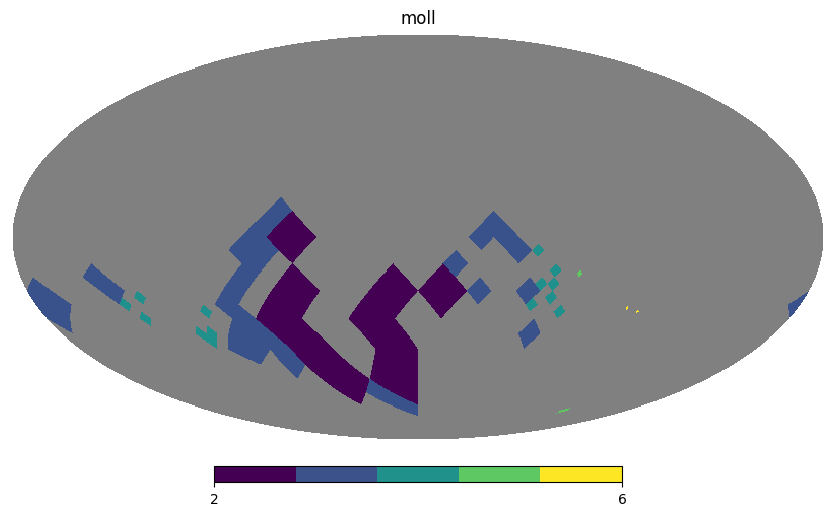

In [12]:
gaia_join_mage = gaia.join(mage, left_on="source_id", right_on="GAIAEDR3_ID")
gaia_join_mage.plot_pixels()

In [13]:
len(gaia_join_mage._ddf_pixel_map)

60

Loading ~3200 partitions would have been unfeasible to run! With this approach, we can get a result in ~50s.

In [14]:
%%time
gaia_join_mage.compute()

CPU times: user 11 s, sys: 2.05 s, total: 13.1 s
Wall time: 49.9 s


,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,circLtot_pot1_MagE,circLtot_pot1_err_MagE,FLAG_MagE,dup_MagE,Sgr_l_MagE,Sgr_b_MagE,Sgr_FLAG_MagE,Norder_MagE,Dir_MagE,Npix_MagE
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
4685349917768548352,1636148068921376768,Gaia DR3 2342674935052997504,2342674935052997504,1338247776,2016.0,13.087946,0.105200,-27.128935,0.096506,0.130856,...,0.000439,0.000012,-1,0,76.070643,13.559833,0,0,0,4
4690649878030712832,1636148068921376768,Gaia DR3 2345324925579432320,2345324925579432320,1182930442,2016.0,12.265058,0.115975,-25.458961,0.078881,0.109161,...,0.000381,0.000009,-1,0,76.240447,11.741711,0,0,0,4
4691121632633159680,1636148068921376768,Gaia DR3 2345560805182848640,2345560805182848640,1409485996,2016.0,12.026699,0.138572,-24.799642,0.125136,0.173321,...,0.480100,0.192823,-1,0,76.371290,11.059935,0,0,0,4
4695899268681039872,1636148068921376768,Gaia DR3 2347949631633156480,2347949631633156480,590326691,2016.0,6.837445,0.143640,-24.189904,0.114738,-0.068040,...,0.122971,0.074652,-1,0,72.430857,8.306080,0,0,0,4
4726358970078330880,1636148068921376768,Gaia DR3 2363179482585844224,2363179482585844224,1090283697,2016.0,10.087718,0.171521,-18.835887,0.079986,0.046147,...,0.679947,0.192806,-1,0,77.620751,4.954772,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13731005943750066176,1636148068921376768,Gaia DR3 6865502954915744768,6865502954915744768,936188752,2016.0,298.075076,0.227863,-20.758670,0.149938,0.168244,...,0.244154,0.102973,-1,0,11.784338,-9.589282,0,0,0,11
13744483107321413632,1636148068921376768,Gaia DR3 6872241556743230720,6872241556743230720,636236736,2016.0,297.454359,0.168389,-15.876531,0.128071,0.239317,...,0.498702,0.105130,-1,0,10.917148,-14.433173,0,0,0,11
13746899243988156416,1636148068921376768,Gaia DR3 6873449606484418944,6873449606484418944,1172524806,2016.0,304.458478,0.148706,-16.790299,0.099977,0.244342,...,0.262972,0.020788,-1,0,17.867100,-13.685044,0,0,0,11


What happens if we performed the operations in reverse, e.g. crossmatching MagE with Gaia instead of the other way around? The partitioning schema (and respective execution time) should be similar because here gaia was provided without a margin cache.

/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/lsdb/dask/crossmatch_catalog_data.py:121: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


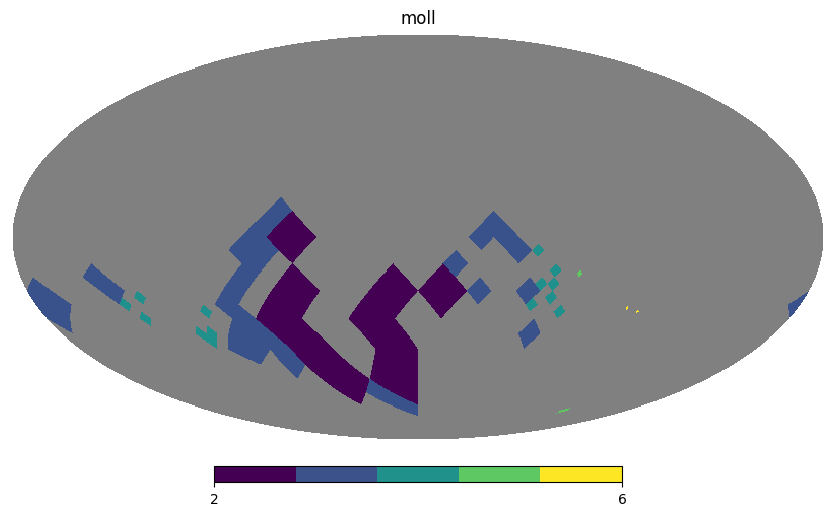

In [15]:
mage_x_gaia = mage.crossmatch(gaia)
mage_x_gaia.plot_pixels()

In [16]:
assert mage_x_gaia.get_healpix_pixels() == gaia_join_mage.get_healpix_pixels()

In [17]:
%%time
mage_x_gaia.compute()

CPU times: user 13.6 s, sys: 2.12 s, total: 15.7 s
Wall time: 46.7 s


,name_MagE,date_MagE,specfile_MagE,mage_ra_MagE,mage_dec_MagE,mage_target_MagE,mage_decker_MagE,mage_binning_MagE,mage_mjd_MagE,mage_airmass_MagE,...,ag_gspphot_lower_gaia,ag_gspphot_upper_gaia,ebpminrp_gspphot_gaia,ebpminrp_gspphot_lower_gaia,ebpminrp_gspphot_upper_gaia,libname_gspphot_gaia,Norder_gaia,Dir_gaia,Npix_gaia,_dist_arcsec
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
4685349917768548352,b'j0052m2707',b'b2022_08_15',b'/n/holyscratch01/conroy_lab/vchandra/mage/da...,13.089583,-27.128583,b'j0052m2707',b'0.7',"b'1,1'",59807.240046,1.142,...,0.0001,0.0015,0.0003,0.0000,0.0009,MARCS,2,0,65,0.000000e+00
4690649878030712832,b'j0049m2527',b'b2022_08_15',b'/n/holyscratch01/conroy_lab/vchandra/mage/da...,12.266250,-25.458861,b'j0049m2527',b'0.7',"b'1,1'",59807.252766,1.099,...,0.0003,0.0037,0.0008,0.0002,0.0021,MARCS,2,0,65,0.000000e+00
4691121632633159680,b'j0048m2447',b'b2022_08_15',b'/n/holyscratch01/conroy_lab/vchandra/mage/da...,12.027917,-24.799444,b'j0048m2447',b'0.7',"b'1,1'",59807.265509,1.067,...,0.0002,0.0022,0.0004,0.0001,0.0012,MARCS,2,0,65,0.000000e+00
4695899268681039872,b'j0027m2411',b'b2022_10_10',b'/n/holyscratch01/conroy_lab/vchandra/mage/da...,6.835833,-24.190250,b'j0027m2411',b'0.7',"b'1,1'",59863.112234,1.042,...,0.0001,0.0019,0.0003,0.0000,0.0011,MARCS,2,0,65,0.000000e+00
4726358970078330880,b'j0040m1850',b'b2022_10_10',b'/n/holyscratch01/conroy_lab/vchandra/mage/da...,10.087500,-18.836472,b'j0040m1850',b'0.7',"b'1,1'",59863.124954,1.051,...,0.0001,0.0021,0.0004,0.0001,0.0011,MARCS,2,0,65,5.724998e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13731005943750066176,b'j1952m2045',b'b2022_10_10',b'/n/holyscratch01/conroy_lab/vchandra/mage/da...,298.074167,-20.757500,b'j1952m2045',b'0.7',"b'1,1'",59862.983264,1.013,...,0.0010,0.0110,0.0025,0.0005,0.0061,MARCS,4,0,3048,1.643384e-10
13744483107321413632,b'j1949m1552',b'b2022_10_10',b'/n/holyscratch01/conroy_lab/vchandra/mage/da...,297.453750,-15.875833,b'j1949m1552',b'0.7',"b'1,1'",59862.950625,1.032,...,0.0072,0.0847,0.0216,0.0039,0.0460,MARCS,4,0,3051,0.000000e+00
13746899243988156416,b'j2017m1647',b'b2022_10_10',b'/n/holyscratch01/conroy_lab/vchandra/mage/da...,304.457917,-16.789167,b'j2017m1647',b'0.7',"b'1,1'",59862.999456,1.026,...,0.0023,0.0188,0.0044,0.0013,0.0103,MARCS,4,0,3052,0.000000e+00


Crossmatching catalogs with a large number of sparsely populated pixels may still face performance bottlenecks. For example, if we look at the AGN catalog, we can confirm that the maximum number of points on a pixel is 758, which is incredibly small. As a result, the crossmatch yields more than 3000 partitions. In this scenario it would be useful to regroup the data into smaller order pixels because matches for AGNs will be located in lower density regions of Gaia (order 2 through 4). This would certainly prevent the duplication of partition readings from Gaia.

In [18]:
agn = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/dr16q_constant/")

/astro/users/smcampos/.conda/envs/py310/lib/python3.10/site-packages/healpy/projaxes.py:951: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap0 = matplotlib.cm.get_cmap(cmap)


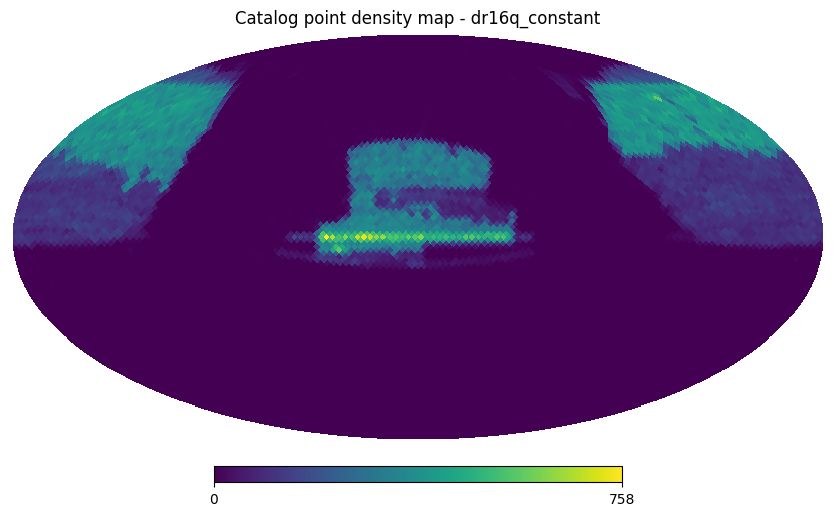

In [19]:
from hipscat.inspection.visualize_catalog import plot_points
plot_points(agn.hc_structure)

In [20]:
alignment_with_mocs = align_catalogs(agn, gaia)
len(alignment_with_mocs.pixel_tree)

3657

## Repartitioning issues

There are two issues around re-partitioning that we can close.

- [Repartitioning object catalog after spatial filtering to improve speed (#133)](https://github.com/astronomy-commons/lsdb/issues/133) is where the discussion started and what we debated was addressed.

- [Repartition to a different catalog structure (#203)](https://github.com/astronomy-commons/lsdb/issues/203) urgency stemmed from the xmatch issue presented above. It has been addressed.

We can also revisit the following two.

- [Repartition a catalog, based on a new threshold (#202)](https://github.com/astronomy-commons/lsdb/issues/202) is still relevant. For example, we might want to generically reduce or increase the number of catalog partitions before saving it to disk. Using a different threshold enables this.

- [Repartition to a fixed pixel order (#219)](https://github.com/astronomy-commons/lsdb/issues/219): do we have use cases for this feature? Crossmatching/joining do not require it anymore.

In [21]:
client.shutdown()